# Important libraries

In [15]:
import matplotlib.pyplot as plt
import tensorflow as tf
import pandas as pd
import numpy as np
import seaborn as sns
import random
import warnings
warnings.filterwarnings('ignore')

from sklearn.metrics import confusion_matrix
from tensorflow import keras
from keras import layers
from vit_keras import vit, utils
from tensorflow.keras.applications import ResNet50, MobileNetV2, DenseNet169
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.layers import Activation, Dropout, Flatten, Dense, GlobalAveragePooling2D
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.utils import image_dataset_from_directory
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img
from tensorflow.keras.preprocessing import image_dataset_from_directory
from sklearn.metrics import roc_curve, roc_auc_score
import os
import matplotlib.image as mpimg


# Accessing libraries ( Image Path )

In [9]:
train_dir = r'C:\Users\MK Jutt\Desktop\MSc Data\My Exercises\Semester 2 CA1 DA&BDP\X-ray labelled\train'
validation_dir = r'C:\Users\MK Jutt\Desktop\MSc Data\My Exercises\Semester 2 CA1 DA&BDP\X-ray labelled\val'
test_dir = r'C:\Users\MK Jutt\Desktop\MSc Data\My Exercises\Semester 2 CA1 DA&BDP\X-ray labelled\test'
num_classes = len(os.listdir(train_dir))
image_height, image_width = (224, 224)
batch_size = 32
num_epochs = 10  # Adjust as needed

# Infected and Normal Images for training

In [10]:
classes = os.listdir(train_dir)

# Define the directories for the X-ray images
PNEUMONIA_dir = os.path.join(train_dir + '/' + classes[0])
NORMAL_dir = os.path.join(train_dir + '/' + classes[1])

# Create lists of the file names in each directory
pneumonia_names = os.listdir(PNEUMONIA_dir)
normal_names = os.listdir(NORMAL_dir)

print('There are ', len(pneumonia_names),
    'images of pneumonia infected in training dataset')
print('There are ', len(normal_names), 'normal images in training dataset')


There are  1341 images of pneumonia infected in training dataset
There are  3875 normal images in training dataset


# Pneumonia Images

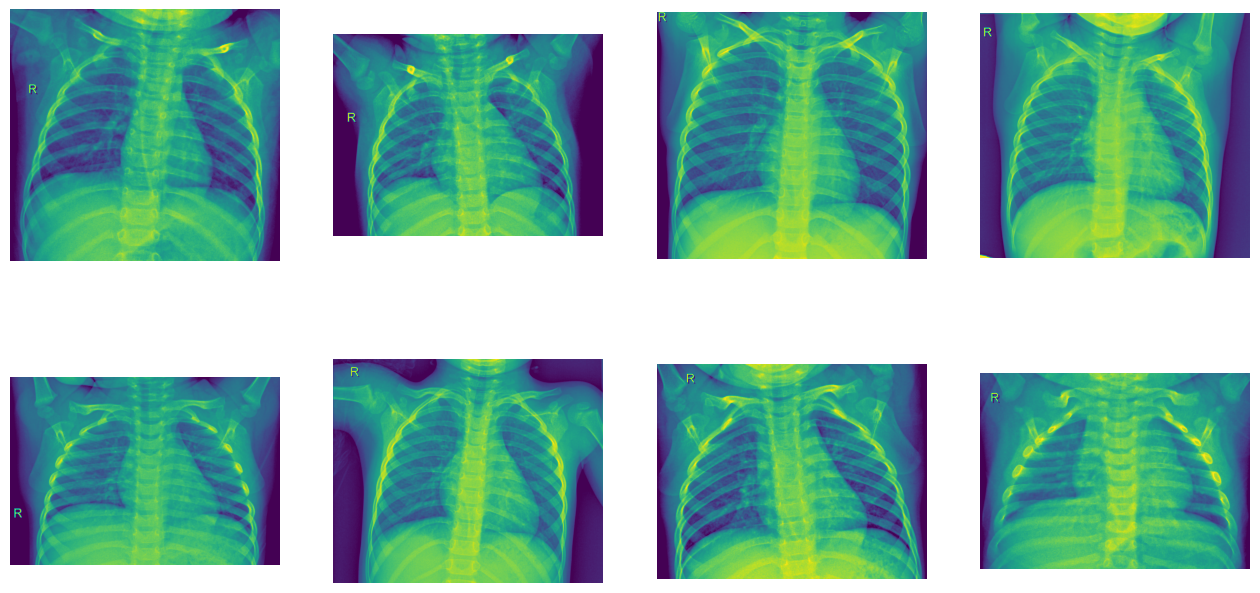

In [11]:
# Set the figure size
fig = plt.gcf()
fig.set_size_inches(16, 8)

# Select the starting index for the images to display
pic_index = 210

# Create lists of the file paths for the 16 images to display
pneumonia_images = [os.path.join(PNEUMONIA_dir, fname)
                    for fname in pneumonia_names[pic_index-8:pic_index]]
# Loop through the image paths and display each image in a subplot
for i, img_path in enumerate(pneumonia_images):
    sp = plt.subplot(2, 4, i+1)
    sp.axis('Off')

# Read in the image using Matplotlib's imread() function
    img = mpimg.imread(img_path)
    plt.imshow(img)

# Display the plot with the 16 images in a 4x4
plt.show()

# Normal Images

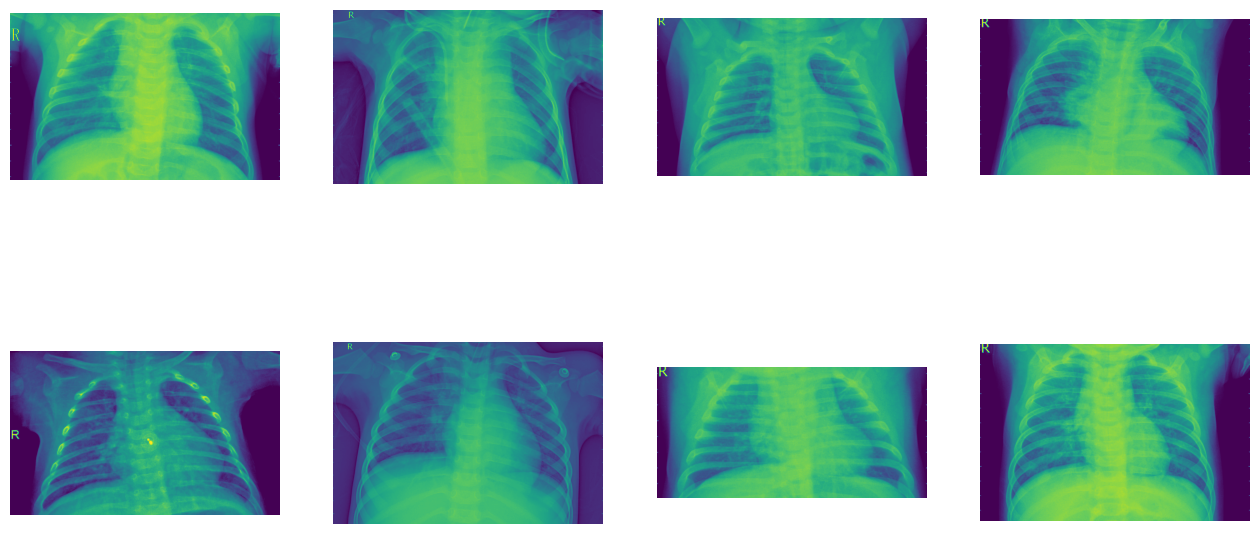

In [12]:
# Set the figure size
fig = plt.gcf()
fig.set_size_inches(16, 8)

# Select the starting index for the images to display
pic_index = 210

# Create lists of the file paths for the 16 images to display
normal_images = [os.path.join(NORMAL_dir, fname)
            for fname in normal_names[pic_index-8:pic_index]]
# Loop through the image paths and display each image in a subplot
for i, img_path in enumerate(normal_images):
    sp = plt.subplot(2, 4, i+1)
    sp.axis('Off')

    # Read in the image using Matplotlib's imread() function
    img = mpimg.imread(img_path)
    plt.imshow(img)

# Display the plot with the 16 images in a 4x4 grid
plt.show()


# Getting images from folders and sub-folders

In [13]:
image_height, image_width = (224, 224)  # Adjust as needed
batch_size = 32                    # Increase the batch size will increase the GPU memorys
#validation_batch_size = 64

train_datagen = ImageDataGenerator(
    rescale=1.0 / 255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

validation_datagen = ImageDataGenerator(rescale=1.0 / 255)
test_datagen = ImageDataGenerator(rescale=1.0 / 255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(image_height, image_width),
    batch_size=batch_size,
    class_mode='categorical',  # Change to 'binary' for binary classification
    shuffle=True
)

validation_generator = validation_datagen.flow_from_directory(
    validation_dir,
    target_size=(image_height, image_width),
    batch_size=batch_size,
    class_mode='categorical',  # Change to 'binary' for binary classification
    shuffle=False
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(image_height, image_width),
    batch_size=batch_size,
    class_mode='categorical',  # Change to 'binary' for binary classification
    shuffle=False
)


Found 5216 images belonging to 2 classes.
Found 126 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


# Pre-Trained Model ResNet50

In [10]:
num_epochs = 5  # Adjust as needed
# Load a pre-trained ResNet50 model
base_model = ResNet50(weights='imagenet',
                      include_top=False,
                      input_shape=(image_height, image_width, 3))

# Add custom layers for your task
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(num_classes, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)

# Freeze the pre-trained layers (optional)
for layer in base_model.layers:
    layer.trainable = False

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // batch_size,
    epochs=num_epochs
)

# Save the fine-tuned model
model.save('xray_fine_tuned_model.h5')

# Later, you can load the model for inference
loaded_model = tf.keras.models.load_model('xray_fine_tuned_model.h5')

# Make predictions using the loaded model
test_datagen = ImageDataGenerator(rescale=1.0 / 255)
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(image_height, image_width),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

predictions = loaded_model.predict(test_generator)


Epoch 1/5
163/163 [==============================] - 541s 3s/step - loss: 0.5918 - accuracy: 0.7176 - val_loss: 0.6974 - val_accuracy: 0.4167
Epoch 2/5
163/163 [==============================] - 438s 3s/step - loss: 0.5179 - accuracy: 0.7446 - val_loss: 0.7081 - val_accuracy: 0.4375
Epoch 3/5
163/163 [==============================] - 430s 3s/step - loss: 0.4845 - accuracy: 0.7609 - val_loss: 0.6632 - val_accuracy: 0.5104
Epoch 4/5
163/163 [==============================] - 504s 3s/step - loss: 0.4590 - accuracy: 0.7690 - val_loss: 0.7252 - val_accuracy: 0.5104
Epoch 5/5
163/163 [==============================] - 442s 3s/step - loss: 0.4437 - accuracy: 0.7745 - val_loss: 0.5642 - val_accuracy: 0.6771
Found 624 images belonging to 2 classes.
20/20 [==============================] - 53s 3s/step


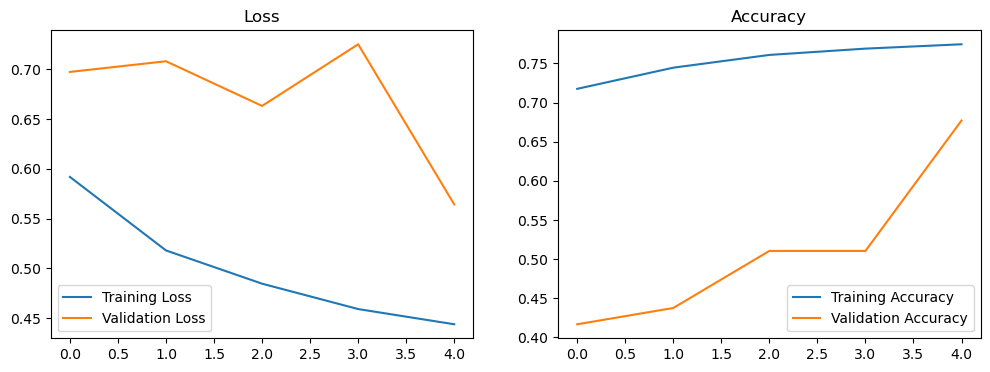

In [11]:
# Plot training history
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Loss')

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.title('Accuracy')

plt.show()

# Pre-trained MobileNetV2 model

In [14]:
num_epochs = 5  # Adjust as needed

# Load a pre-trained MobileNetV2 model
base_model = MobileNetV2(weights='imagenet',
                          include_top=False,
                          input_shape=(image_height, image_width, 3))

# Add custom layers for your task
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(num_classes, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)

# Freeze the pre-trained layers (optional)
for layer in base_model.layers:
    layer.trainable = False

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // batch_size,
    epochs=num_epochs
)

# Save the fine-tuned model
model.save('xray_fine_tuned_mobilenetv2_model.h5')

# Later, you can load the model for inference
loaded_model = tf.keras.models.load_model('xray_fine_tuned_mobilenetv2_model.h5')

# Make predictions using the loaded model
test_datagen = ImageDataGenerator(rescale=1.0 / 255)
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(image_height, image_width),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

predictions = loaded_model.predict(test_generator)

9406464/9406464 [==============================] - 5s 1us/step
Epoch 1/5
163/163 [==============================] - 211s 1s/step - loss: 0.2880 - accuracy: 0.8871 - val_loss: 0.1365 - val_accuracy: 0.9792
Epoch 2/5
163/163 [==============================] - 198s 1s/step - loss: 0.1785 - accuracy: 0.9256 - val_loss: 0.1255 - val_accuracy: 0.9688
Epoch 3/5
163/163 [==============================] - 237s 1s/step - loss: 0.1613 - accuracy: 0.9369 - val_loss: 0.1737 - val_accuracy: 0.9167
Epoch 4/5
163/163 [==============================] - 314s 2s/step - loss: 0.1518 - accuracy: 0.9375 - val_loss: 0.1984 - val_accuracy: 0.9062
Epoch 5/5
163/163 [==============================] - 290s 2s/step - loss: 0.1409 - accuracy: 0.9444 - val_loss: 0.1101 - val_accuracy: 0.9688
Found 624 images belonging to 2 classes.
20/20 [==============================] - 27s 1s/step


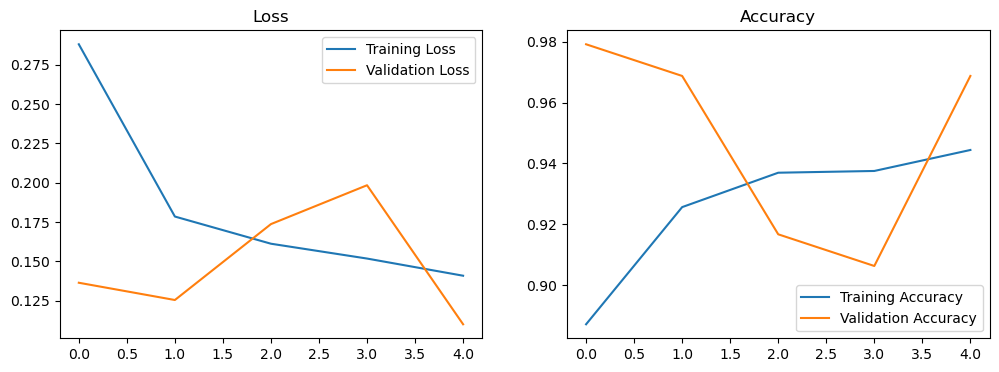

In [15]:
# Plot training history
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Loss')

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.title('Accuracy')

plt.show()

# Pre-Trained DenseNet169 model

In [18]:
num_epochs = 5  # Adjust as needed

# Load a pre-trained DenseNet169 model
base_model = DenseNet169(weights='imagenet',
                         include_top=False,
                         input_shape=(image_height, image_width, 3))

# Add custom layers for your task
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(num_classes, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)

# Freeze the pre-trained layers (optional)
for layer in base_model.layers:
    layer.trainable = False

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // batch_size,
    epochs=num_epochs
)

# Save the fine-tuned model
model.save('xray_fine_tuned_densenet169_model.h5')

# Later, you can load the model for inference
loaded_model = tf.keras.models.load_model('xray_fine_tuned_densenet169_model.h5')

# Make predictions using the loaded model
test_datagen = ImageDataGenerator(rescale=1.0 / 255)
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(image_height, image_width),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

predictions = loaded_model.predict(test_generator)


Epoch 1/5
163/163 [==============================] - 632s 4s/step - loss: 0.2607 - accuracy: 0.8993 - val_loss: 0.1166 - val_accuracy: 0.9688
Epoch 2/5
163/163 [==============================] - 632s 4s/step - loss: 0.1811 - accuracy: 0.9268 - val_loss: 0.1579 - val_accuracy: 0.9271
Epoch 3/5
163/163 [==============================] - 609s 4s/step - loss: 0.1572 - accuracy: 0.9411 - val_loss: 0.0999 - val_accuracy: 0.9375
Epoch 4/5
163/163 [==============================] - 602s 4s/step - loss: 0.1533 - accuracy: 0.9400 - val_loss: 0.1532 - val_accuracy: 0.9271
Epoch 5/5
163/163 [==============================] - 600s 4s/step - loss: 0.1469 - accuracy: 0.9427 - val_loss: 0.1497 - val_accuracy: 0.9375
Found 624 images belonging to 2 classes.
20/20 [==============================] - 72s 3s/step


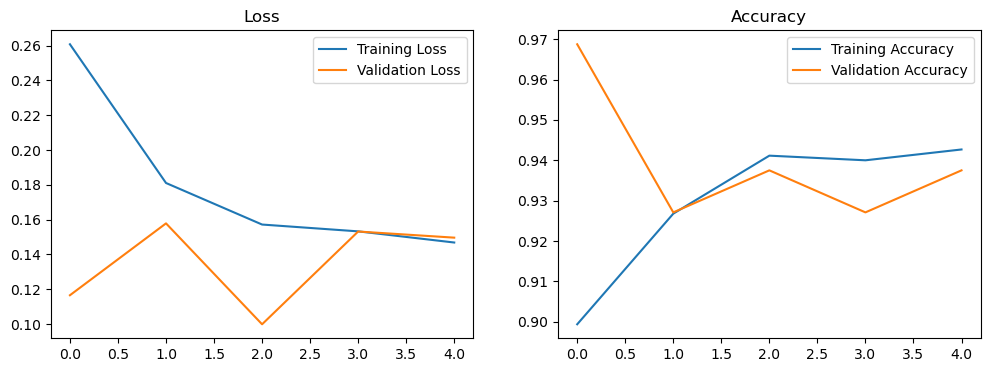

In [19]:
# Plot training history
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Loss')

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.title('Accuracy')

plt.show()

# CNN Modeling

# Optimization

In [17]:
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=1e-4,
    decay_steps=1000,
    decay_rate=0.9
)

optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)

# Early Stopping

In [18]:
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True
)

# Applying the Convolutional layers

In [19]:
# Define your model architecture
model = tf.keras.Sequential([
    # Convolutional layer 1
    Conv2D(32, (3, 3), activation='relu', input_shape=(image_height, image_width, 3)),
    MaxPooling2D((2, 2)),

    # Convolutional layer 2
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),

    # Convolutional layer 3 (optional)
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),

    # Flatten the feature maps
    Flatten(),

    # Fully connected layer 1
    Dense(128, activation='relu'),

    # Dropout layer to reduce overfitting (optional)
    Dropout(0.5),

    # Output layer for classification
    Dense(num_classes, activation='softmax')
])

# Compile your model with an optimizer and a loss function
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)  # You can adjust the learning rate
loss = 'categorical_crossentropy'  # Use the appropriate loss function for your problem

model.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])

# Now you can train or evaluate your model


In [20]:
print(f"Number of training batches: {len(train_generator)}")
print(f"Number of validation batches: {len(validation_generator)}")

Number of training batches: 163
Number of validation batches: 4


In [22]:
# Compile your model with an optimizer and a loss function
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)  # You can adjust the learning rate
loss = 'categorical_crossentropy'  # Use the appropriate loss function for your problem

In [23]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 222, 222, 32)      896       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 111, 111, 32)     0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 109, 109, 64)      18496     
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 54, 54, 64)       0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 52, 52, 128)       73856     
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 26, 26, 128)     

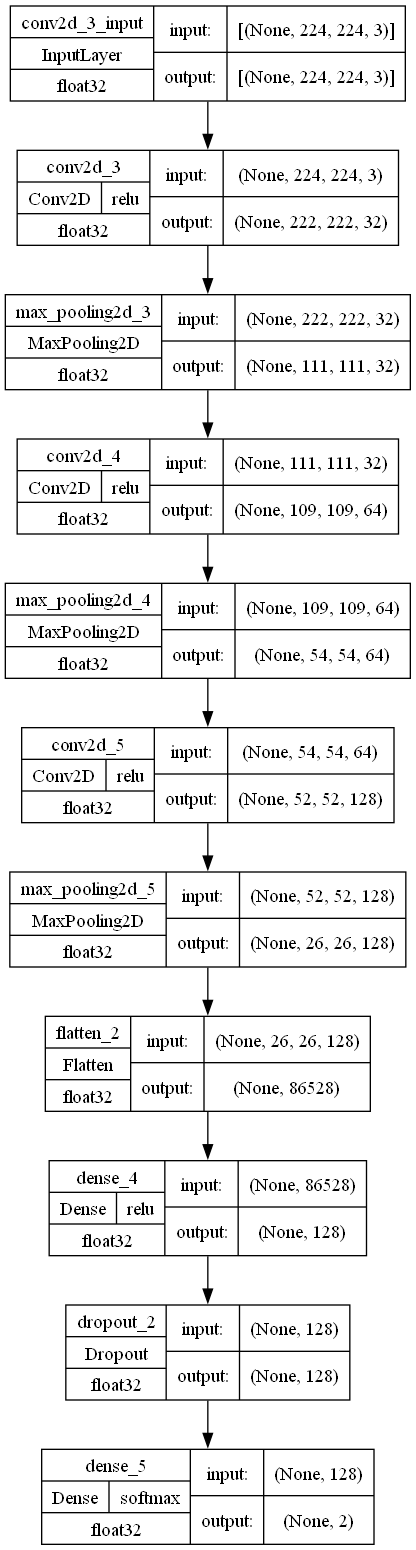

In [24]:
# Plot the keras model
keras.utils.plot_model(
    model,
# show the shapes of the input/output tensors of each layer
    show_shapes=True,
# show the data types of the input/output tensors of each layer
    show_dtype=True,
# show the activations of each layer in the output graph
    show_layer_activations=True
)


In [25]:
model.compile(
# specify the loss function to use during training
    loss=loss,
# specify the optimizer algorithm to use during training
    optimizer=optimizer,
# specify the evaluation metrics to use during training
    metrics=['accuracy']
)


# Model Fitted and checked with different epoch

In [26]:
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // batch_size,
    epochs=5,  # Adjust as needed 10, 30 and 60
    callbacks=[early_stopping]
)

Epoch 1/5
163/163 [==============================] - 610s 4s/step - loss: 0.3518 - accuracy: 0.8357 - val_loss: 0.3439 - val_accuracy: 0.8854
Epoch 2/5
163/163 [==============================] - 386s 2s/step - loss: 0.3078 - accuracy: 0.8595 - val_loss: 0.2543 - val_accuracy: 0.8958
Epoch 3/5
163/163 [==============================] - 388s 2s/step - loss: 0.2758 - accuracy: 0.8777 - val_loss: 0.2632 - val_accuracy: 0.9167
Epoch 4/5
163/163 [==============================] - 501s 3s/step - loss: 0.2821 - accuracy: 0.8808 - val_loss: 0.2824 - val_accuracy: 0.8854
Epoch 5/5
163/163 [==============================] - 518s 3s/step - loss: 0.2643 - accuracy: 0.8840 - val_loss: 0.2562 - val_accuracy: 0.9167


In [27]:
model.save("model.h5")

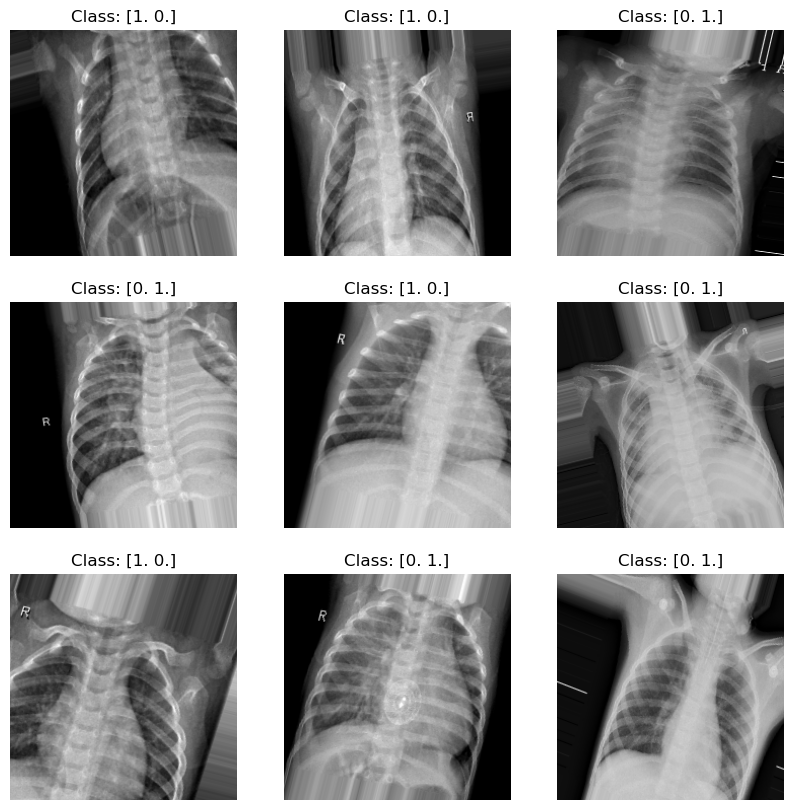

In [28]:
# Plot sample images from the training dataset
sample_images, sample_labels = next(train_generator)
plt.figure(figsize=(10, 10))
for i in range(9):
    plt.subplot(3, 3, i + 1)
    plt.imshow(sample_images[i])
    plt.title(f'Class: {sample_labels[i]}')
    plt.axis('off')
plt.show()

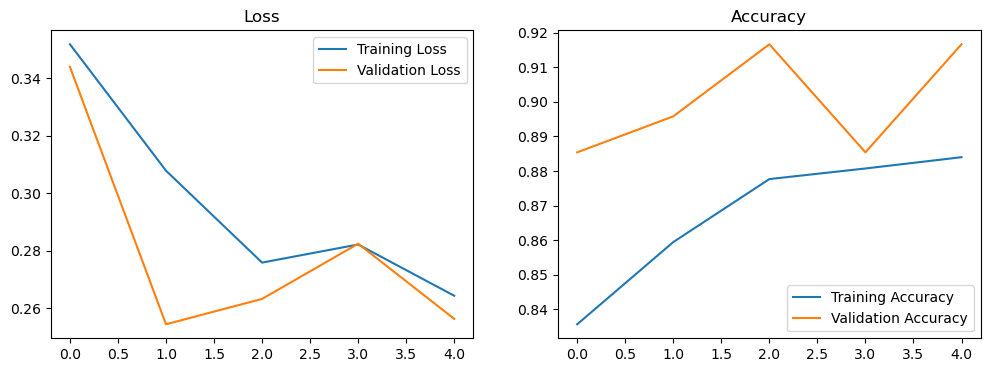

In [29]:
# Plot training history
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Loss')

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.title('Accuracy')

plt.show()

20/20 [==============================] - 21s 1s/step


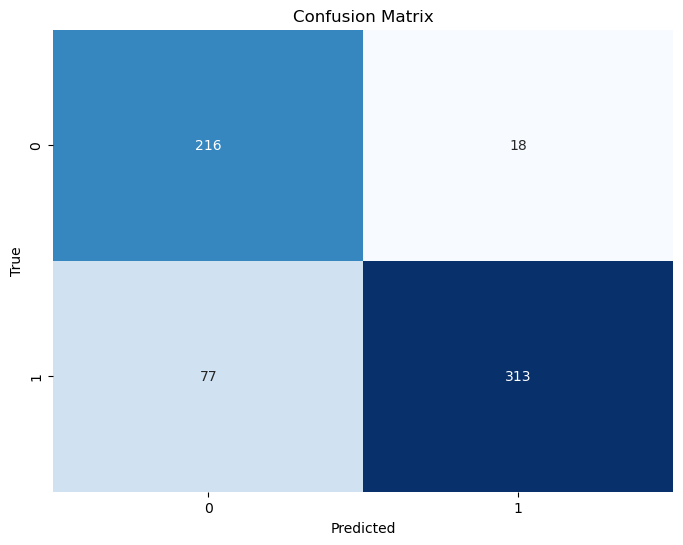

In [30]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import numpy as np

# Generate predictions from your model
predictions = model.predict(test_generator)
y_pred = np.argmax(predictions, axis=1)
y_true = test_generator.classes

# Create a confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


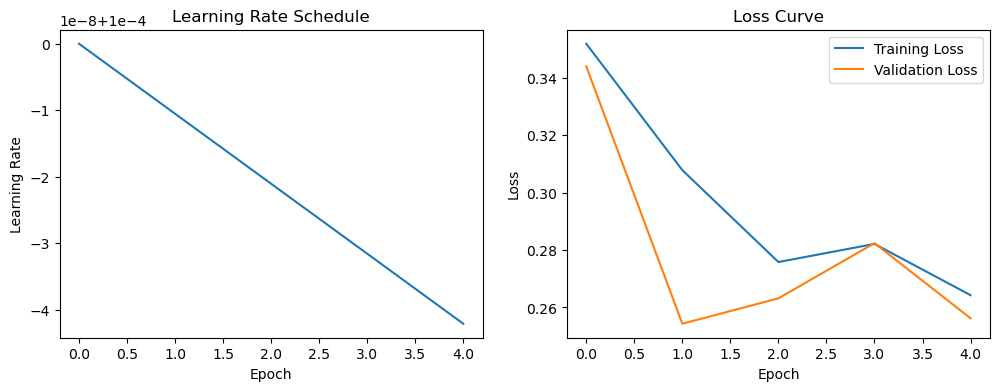

In [31]:
epochs = len(history.history['loss'])
lr = lr_schedule(tf.range(epochs))

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(range(epochs), lr, label='Learning Rate')
plt.xlabel('Epoch')
plt.ylabel('Learning Rate')
plt.title('Learning Rate Schedule')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss Curve')
plt.legend()
plt.show()


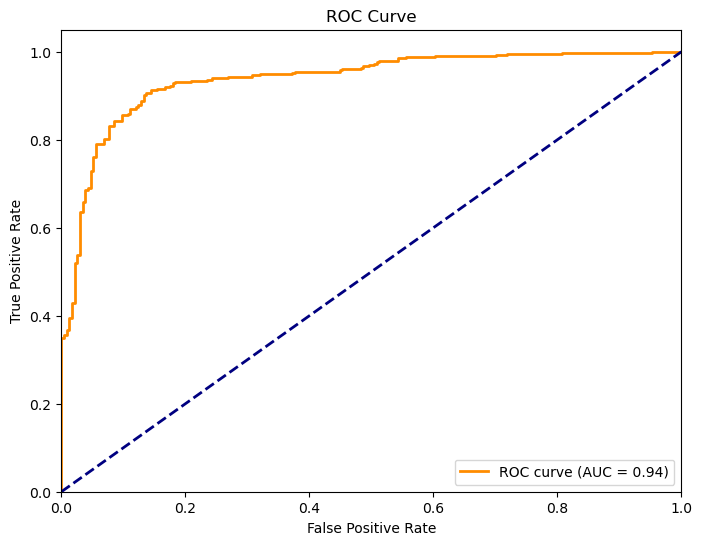

In [32]:
# Compute ROC curve and AUC
fpr, tpr, _ = roc_curve(y_true, predictions[:, 1])
roc_auc = roc_auc_score(y_true, predictions[:, 1])

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()


1/1 [==============================] - 0s 96ms/step


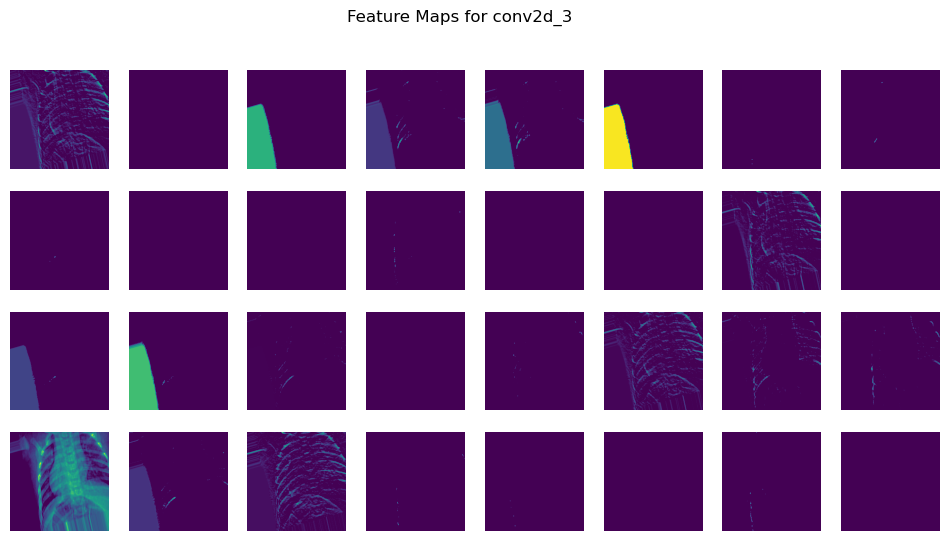

In [38]:
layer_name = 'conv2d_3'  # Replace with the layer name you want to visualize
intermediate_layer_model = Model(inputs=model.input, outputs=model.get_layer(layer_name).output)
intermediate_output = intermediate_layer_model.predict(sample_images[0:1])

plt.figure(figsize=(12, 6))
for i in range(intermediate_output.shape[-1]):
    plt.subplot(4, 8, i + 1)
    plt.imshow(intermediate_output[0, :, :, i], cmap='viridis')
    plt.axis('off')
plt.suptitle(f'Feature Maps for {layer_name}')
plt.show()


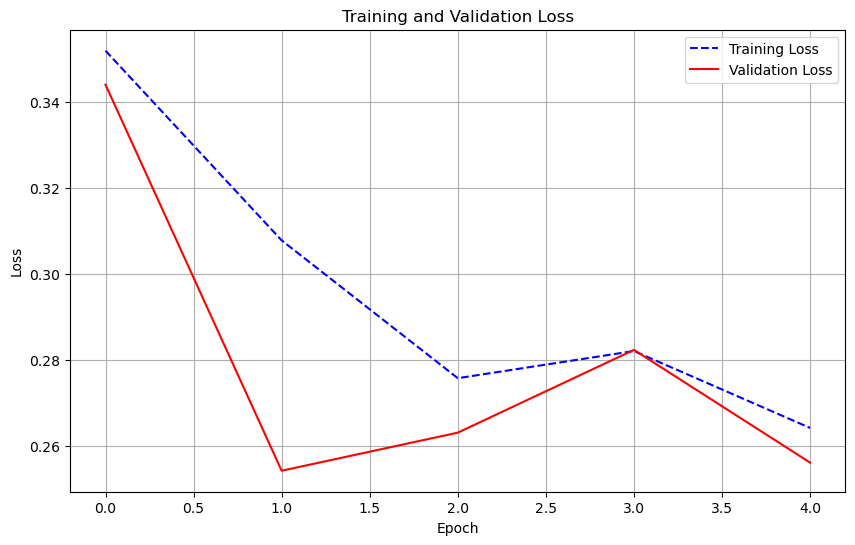

In [39]:
# Plot training and validation loss
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss', color='blue', linestyle='--')
plt.plot(history.history['val_loss'], label='Validation Loss', color='red')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid(True)
plt.show()


# Predicted the 10 samples for Pneumonia

20/20 [==============================] - 11s 504ms/step
Number of images predicted as Pneumonia: 624
Predicted: Pneumonia
True: Pneumonia


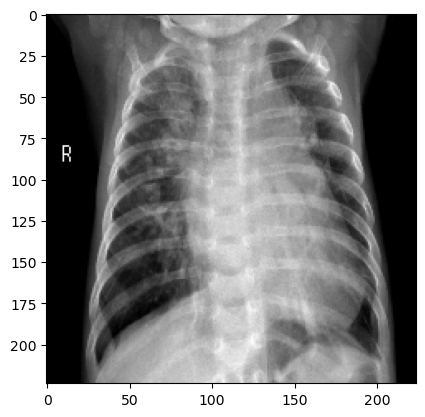

Predicted: Pneumonia
True: Pneumonia


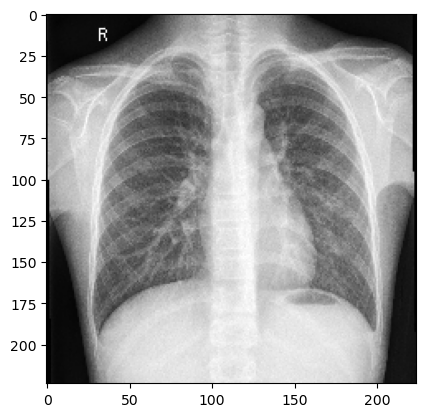

Predicted: Pneumonia
True: Pneumonia


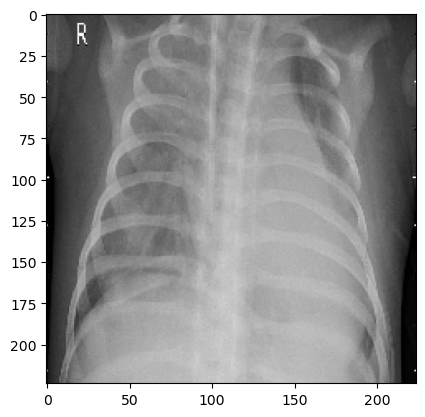

Predicted: Pneumonia
True: Pneumonia


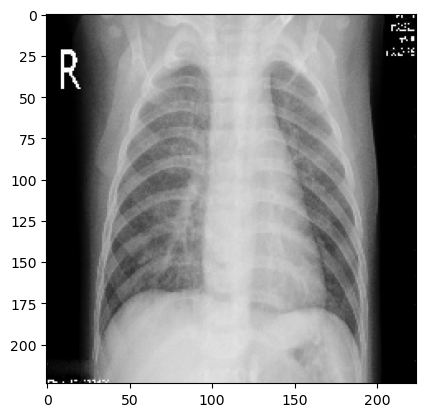

Predicted: Pneumonia
True: Pneumonia


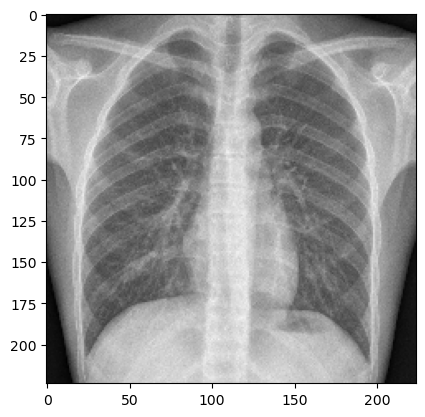

Predicted: Pneumonia
True: Pneumonia


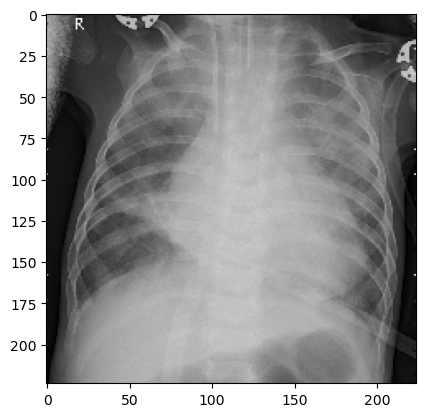

Predicted: Pneumonia
True: Pneumonia


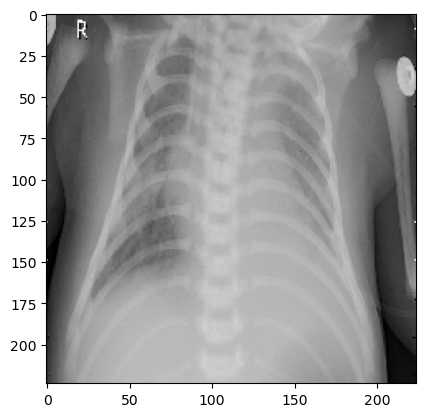

Predicted: Pneumonia
True: Pneumonia


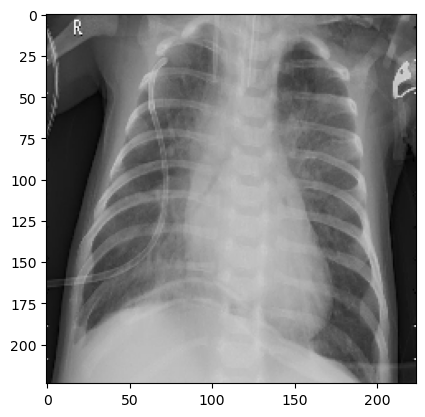

Predicted: Pneumonia
True: Pneumonia


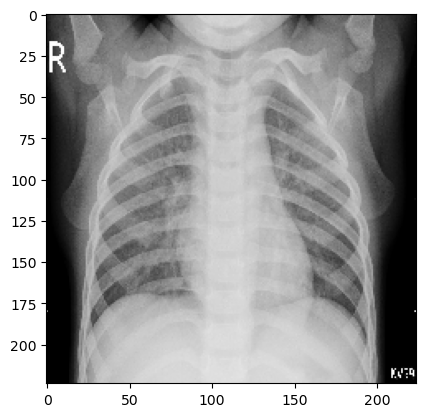

Predicted: Pneumonia
True: Pneumonia


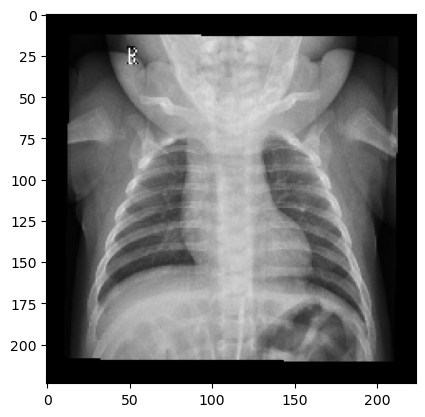

In [40]:
# Assuming you have trained your model and you have a test generator
test_predictions = model.predict(test_generator)

# Apply a threshold to predictions (e.g., 0.5)
threshold = 0.5
pneumonia_predictions = (test_predictions >= threshold).astype(int)

# Count how many images are predicted as pneumonia
num_pneumonia_cases = np.sum(pneumonia_predictions)
print(f"Number of images predicted as Pneumonia: {num_pneumonia_cases}")

# Inspect random test samples and their predictions
num_samples_to_inspect = 10  # Adjust as needed
random_indices = random.sample(range(len(test_generator)), num_samples_to_inspect)

for idx in random_indices:
    img, true_label = test_generator[idx]
    predicted_label = pneumonia_predictions[idx]

    if np.any(predicted_label == 1):
        print("Predicted: Pneumonia")
    else:
        print("Predicted: Non-Pneumonia")

    if np.any(true_label[0] == 1):
        print("True: Pneumonia")
    else:
        print("True: Non-Pneumonia")

    plt.imshow(img[0])
    plt.show()


# Below Code is to check the size of the image

In [41]:
import tensorflow as tf
from tensorflow.keras.preprocessing import image
import numpy as np

# Define the path to a sample image from your dataset
sample_image_path = r'C:\Users\MK Jutt\Desktop\MSc Data\My Exercises\Semester 2 CA1 DA&BDP\X-ray labelled\chesttrain\PNEUMONIA\person13_bacteria_49.jpeg'  # Replace with the actual path

# Load the sample image
img = image.load_img(sample_image_path, target_size=(image_height, image_width))
img_array = image.img_to_array(img)

# Verify the dimensions and data type of the image
print(f"Image shape: {img_array.shape}")
print(f"Image data type: {img_array.dtype}")

# Verify the pixel values (min, max)
min_pixel_value = np.min(img_array)
max_pixel_value = np.max(img_array)
print(f"Min pixel value: {min_pixel_value}")
print(f"Max pixel value: {max_pixel_value}")

# # Check if pixel values are within the expected range (0-1 or -1 to 1)

# if (min_pixel_value >= 0 and max_pixel_value <= 1) or (min_pixel_value >= -1 and max_pixel_value <= 1):
#     print("Pixel values are within the expected range.")
# else:
#     print("Pixel values are outside the expected range.")


Image shape: (224, 224, 3)
Image data type: float32
Min pixel value: 0.0
Max pixel value: 255.0
